# Image Quality Assessment

###### Oleh : Nur Asiah 0102514015


Keterangan eksplorasi 

Dataset yang dipakai adalah data gambar dari toko online OLX Indonesia yan sudah diberi label [`good`, `bad`].



In [99]:
from __future__ import print_function
from collections import Counter


import glob
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", context="talk", palette="Set3")
RANDOM_STATE = 1337
np.random.seed(RANDOM_STATE)

%matplotlib inline

## Eksplorasi data

Jalankan cell di bawah hanya jika tidak memiliki file numpy.

In [3]:
X = []
y = []

for kelas in ['good', 'bad']:
    for img in glob.glob('dataset/'+ kelas +'/*'):
        y += [kelas]
        image = cv2.imread(img)
        X += [np.array(image)]

#X = np.asarray(X)
#y = np.asarray(y)

In [4]:
np.save('images.npy', X)
np.save('labels.npy', y)

Show Images

In [18]:
X = np.load('images.npy')
y = np.load('labels.npy') 

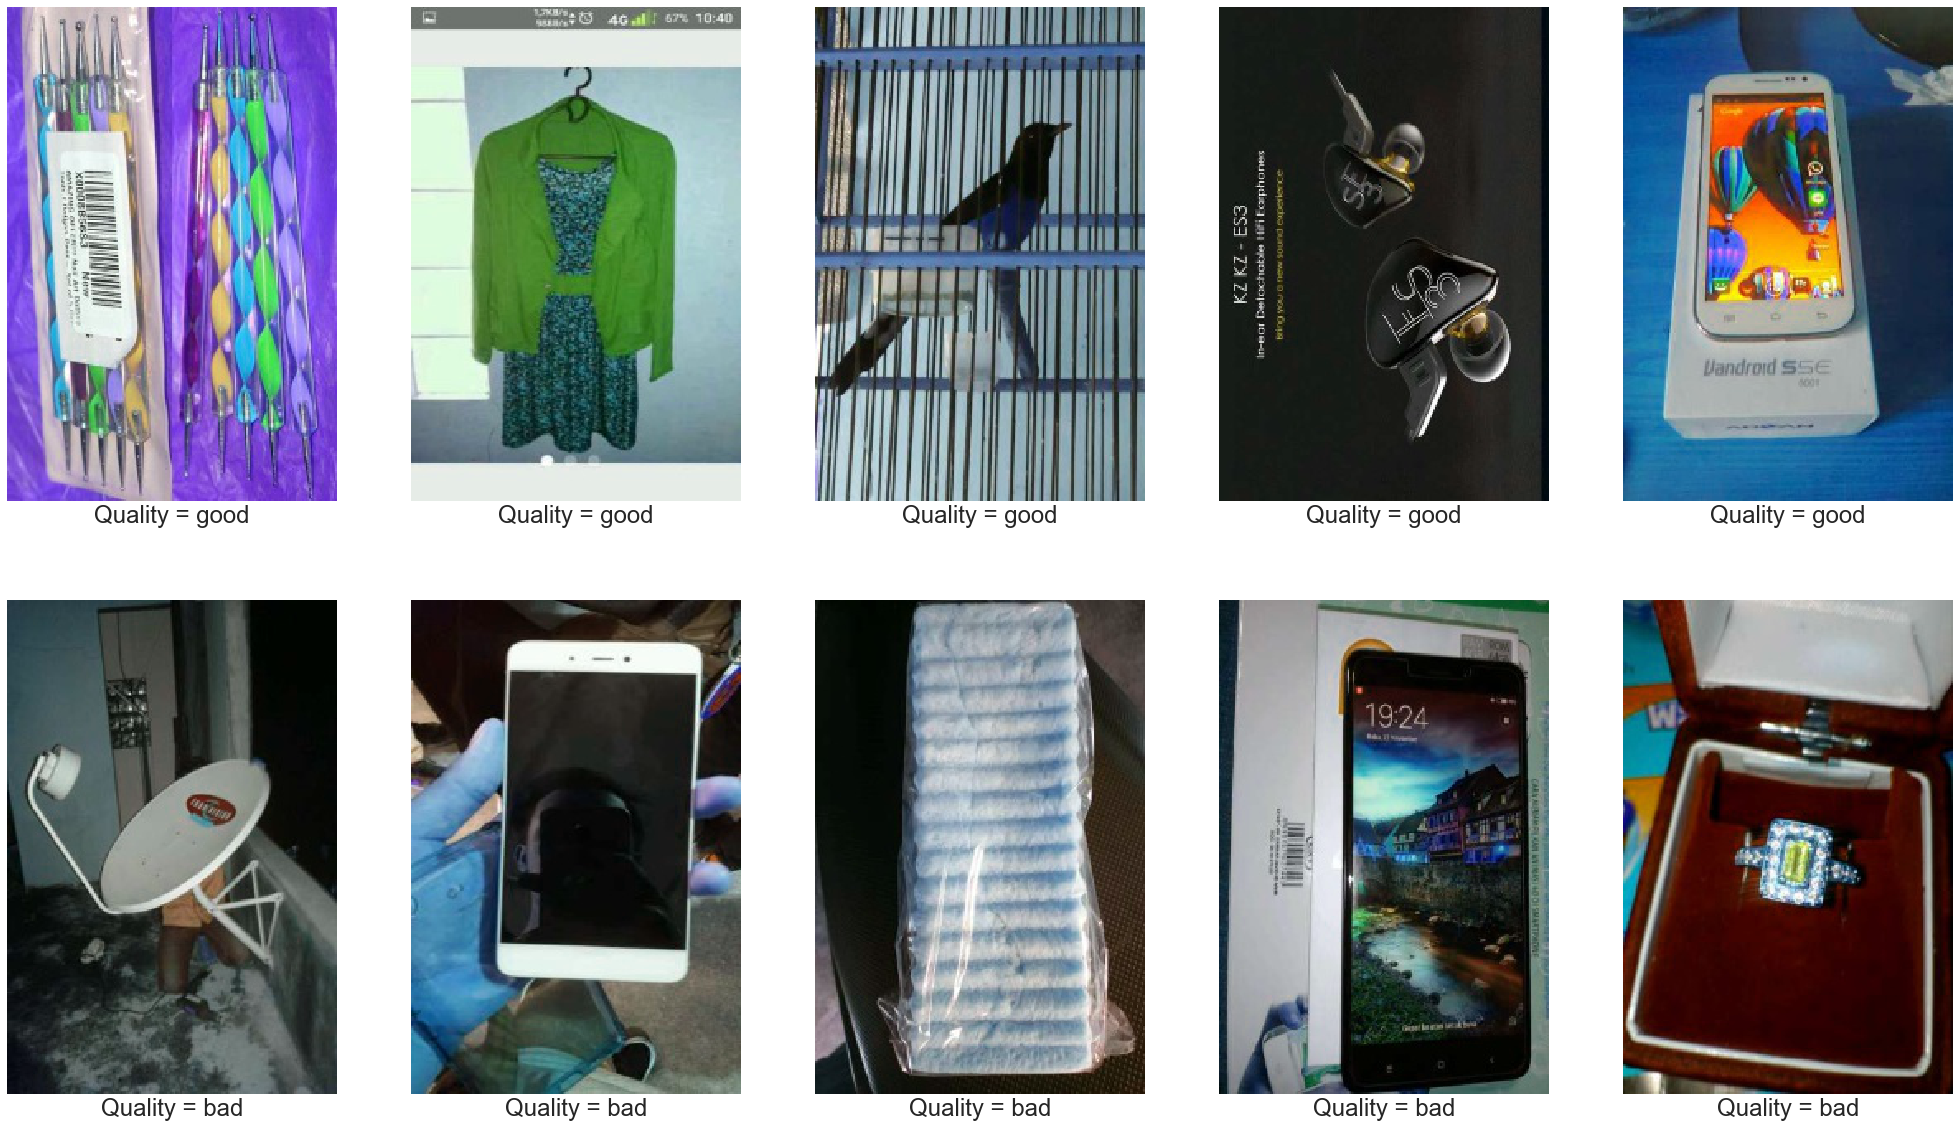

In [76]:
fig = plt.figure(figsize=(35,20))
count = 1
for kelas in ['good', 'bad']:
    images_by_class, label_by_class = X[y == kelas], y[y == kelas]
    for i in range(5):
        fig.add_subplot(2,5,count)
        rand = np.random.randint(0, images_by_class.shape[0])
        plt.imshow(images_by_class[rand], cmap = None)
        count += 1
        
        plt.grid(False)
        plt.xlabel('Quality = ' + str(label_by_class[rand]), fontsize=24)
        plt.xticks([])
        plt.yticks([])
plt.show()

C:\Users\nurul\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  # Do this after plotting so that the numerical axis limits are correct


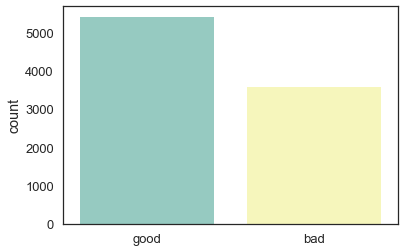

In [112]:
sns.countplot(x=y)